 # Voxel Stability Mask Generation


In [1]:
import numpy as np
import nibabel as nb
import os
from nilearn.image import threshold_img
from joblib import Parallel, delayed
from nilearn import plotting

In [2]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_02_factors')
output_dir   = os.path.join(root_dir, 'derivatives', 'mvpa_02_factors_temp')

# brain masks
#mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c.nii')
#mask_gm_file    = os.path.join(root_dir, 'derivatives', 'mni_icbm152_gm_tal_nlin_asym_09c_res-2_dilated.nii')

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_factors_dataset.nii.gz') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_factors_trial_types.txt') & f.startswith('sub-')]
label_files.sort()

In [4]:
# concatenate all datasets
D = nb.concat_images(dataset_files, axis=3)

In [5]:
# concatenate all labels into a single string array
labels = np.concatenate([np.loadtxt(l, dtype=str) for l in label_files])

# trim each label to remove the 2 digit number in the end
labels = np.array([l[:-2] for l in labels])

In [6]:
D.shape

(97, 115, 97, 1224)

In [7]:
labels

array(['Sublimity', 'Sublimity', 'Sublimity', ..., 'Sublimity',
       'Sublimity', 'Sublimity'], dtype='<U9')

In [8]:
# unique labels
cond_names = np.unique(labels)
cond_names

array(['Sublimity', 'Unease', 'Vitality'], dtype='<U9')

In [9]:
# Final matrix dimension (97, 115, 97, n_subjects * 4 * 2 , n_conditions)

# initialize matrix
# 5 emotions that match sublimity, 4 runs, 2 trials per run
n_rows = 13 * 4 * 2 * 5
X = np.zeros((97, 115, 97, n_rows, len(cond_names))) # -> to save the data in a suitable way to then estimate pairwise correlations

for ii, cond in enumerate(cond_names):

    # find the indices of the current condition
    idx = np.where(labels == cond)[0]

    a = np.asarray(D.dataobj)[..., idx] #all voxels responses to the current condition
    
    if a.shape[-1] != n_rows:
        # oversample
        a = np.concatenate([a, a, a], axis=-1) # recreate 6 emotions that match unsease and vitality

    X[..., ii] = a[..., :n_rows] # cut up to 5 (n_rows)


In [10]:
X.shape

(97, 115, 97, 520, 3)

In [13]:
# create pairs of indexes for each subject
n_subjects = 13

idx_pairs_ss = np.zeros([n_subjects,28,2], dtype=int)

for ss in range(n_subjects):
    idx_pairs_ss[ss] = np.array([[i, j] for i in range(8*ss,8+8*ss) for j in range(i+1, 8+8*ss)])

idx_pairs_ss.shape

(13, 28, 2)

In [18]:
idx_pairs_ss[12,:]

array([[ 96,  97],
       [ 96,  98],
       [ 96,  99],
       [ 96, 100],
       [ 96, 101],
       [ 96, 102],
       [ 96, 103],
       [ 97,  98],
       [ 97,  99],
       [ 97, 100],
       [ 97, 101],
       [ 97, 102],
       [ 97, 103],
       [ 98,  99],
       [ 98, 100],
       [ 98, 101],
       [ 98, 102],
       [ 98, 103],
       [ 99, 100],
       [ 99, 101],
       [ 99, 102],
       [ 99, 103],
       [100, 101],
       [100, 102],
       [100, 103],
       [101, 102],
       [101, 103],
       [102, 103]])

In [26]:
# define function to estimate stability per subject
def estimate_stability(idx_pairs, X, sub):
    print(f'subject {sub+1}')
    STAB = np.zeros((97, 115, 97)) # to save stability per voxel
    for i in range(97):
        for j in range(115):
            for k in range(97):

                # print(f'Processing voxel {i}, {j}, {k}')

                C = np.zeros((len(idx_pairs), 1)) # correlation per pair
                
                for p in range(len(idx_pairs)):
                    # compute the correlation matrix
                    C[p] = np.corrcoef(X[i, j, k, idx_pairs[p,0], :], X[i, j, k, idx_pairs[p,1], :])[0,1]

                if np.isnan(C).any():
                    STAB[i, j, k] = 0
                else:
                    STAB[i, j, k] = np.mean(C)

    # save STAB
    np.save(os.path.join(output_dir, f'sub-{sub+1:02d}_STAB.npy'), STAB)
    return STAB

In [27]:
# iterate on the subjects in parallel
# create combinations of subjects and runs
#combinations = [(subj, run) for subj in subjectList for run in runList]

# iterate on combinations in parallel
Parallel(n_jobs=7)(delayed(estimate_stability)(idx_pairs_ss[subj], X, subj) for subj in range(n_subjects))

subject 2
subject 1
subject 3
subject 4
subject 5
subject 6
subject 7


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: Runtime

subject 8
subject 9
subject 10
subject 11
subject 12
subject 13


[array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [4]:
# Load all *_STAB.npy files in output_dir
STAB_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('_STAB.npy') & f.startswith('sub-')]
STAB_files.sort()

# load all STAB files
STAB = np.zeros((97, 115, 97, 13))
for ii, f in enumerate(STAB_files):
    STAB[..., ii] = np.load(f)

In [5]:
# compute the mean stability
STAB_mean = np.mean(STAB, axis=3)

In [9]:
# estimate mean stability map
STAB_mean_img = nb.Nifti1Image(STAB_mean, D.affine, D.header)

# threshold the stability map
thres = 0.3
STAB_mean_img_thr = threshold_img(STAB_mean_img, threshold=thres)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



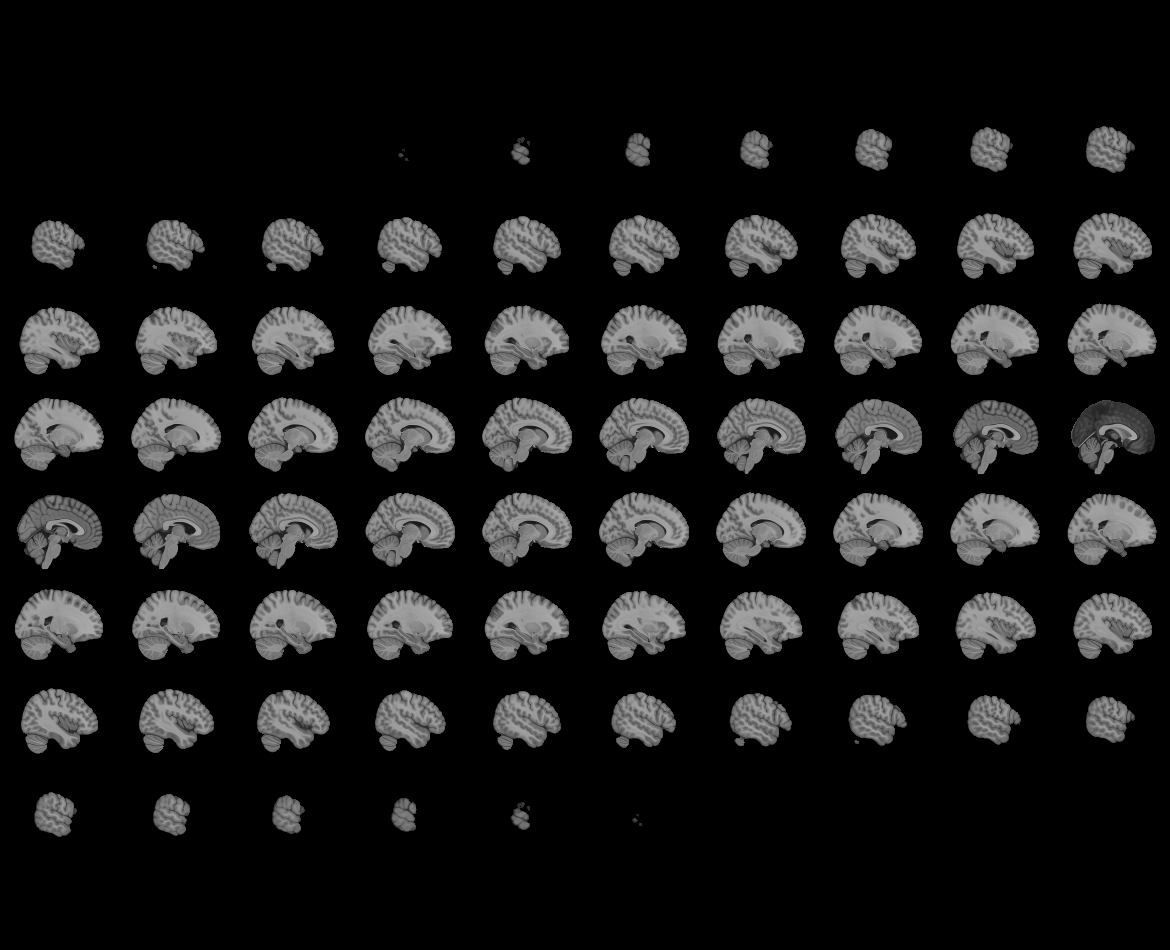
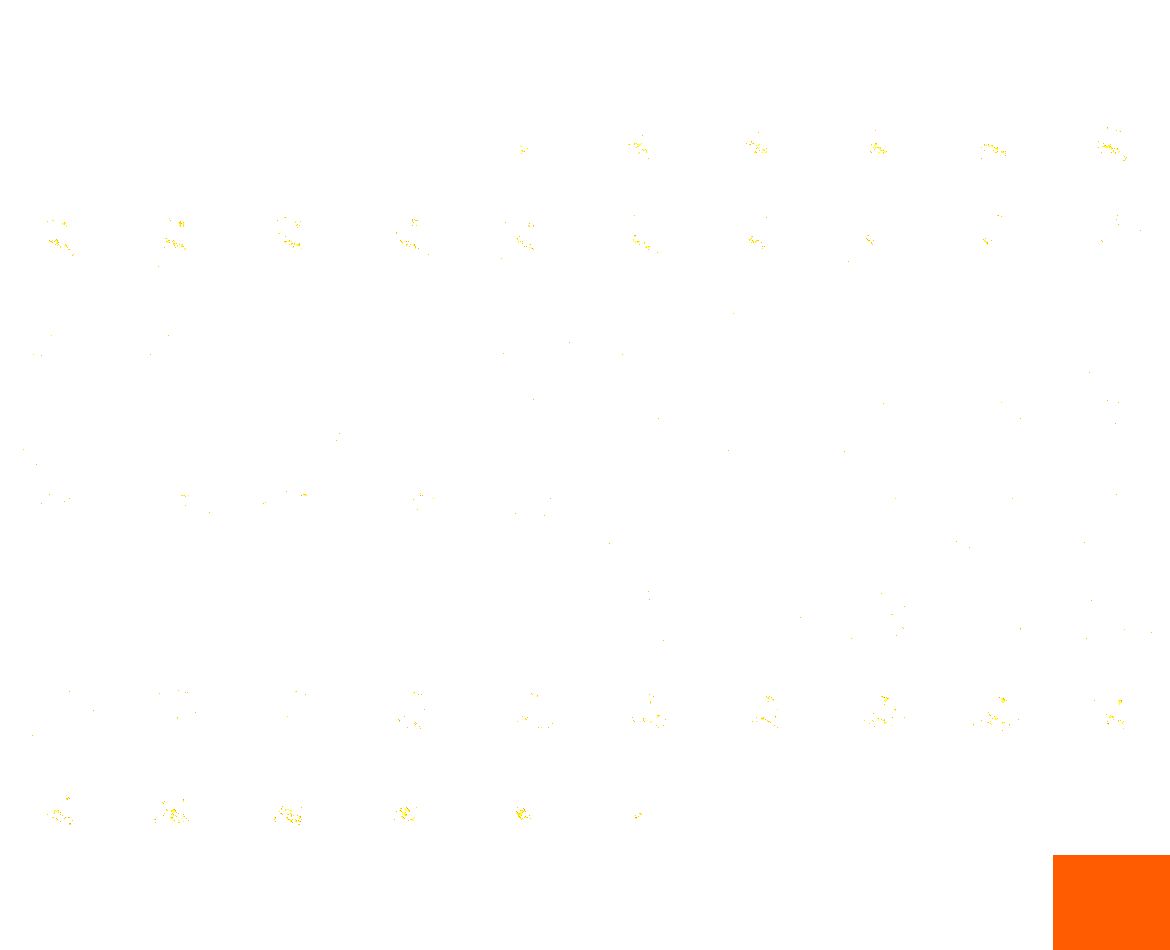

In [10]:
# plot STAB_mean_img_thr with view_img
plotting.view_img(STAB_mean_img_thr, title='STAB', colorbar=True, cmap='hot')

In [11]:
#count number of voxels > 0
print(np.sum(STAB_mean_img_thr.get_fdata() > 0))

1066


In [12]:
# binarize STAB_mean_img_thr
STAB_mean_img_thr_bin = nb.Nifti1Image((STAB_mean_img_thr.get_fdata() > 0).astype(int), STAB_mean_img_thr.affine, STAB_mean_img_thr.header)

# save STAB_mean_img_thr_bin
STAB_mean_img_thr_bin.to_filename(os.path.join(output_dir, 'STAB_mask.nii.gz'))

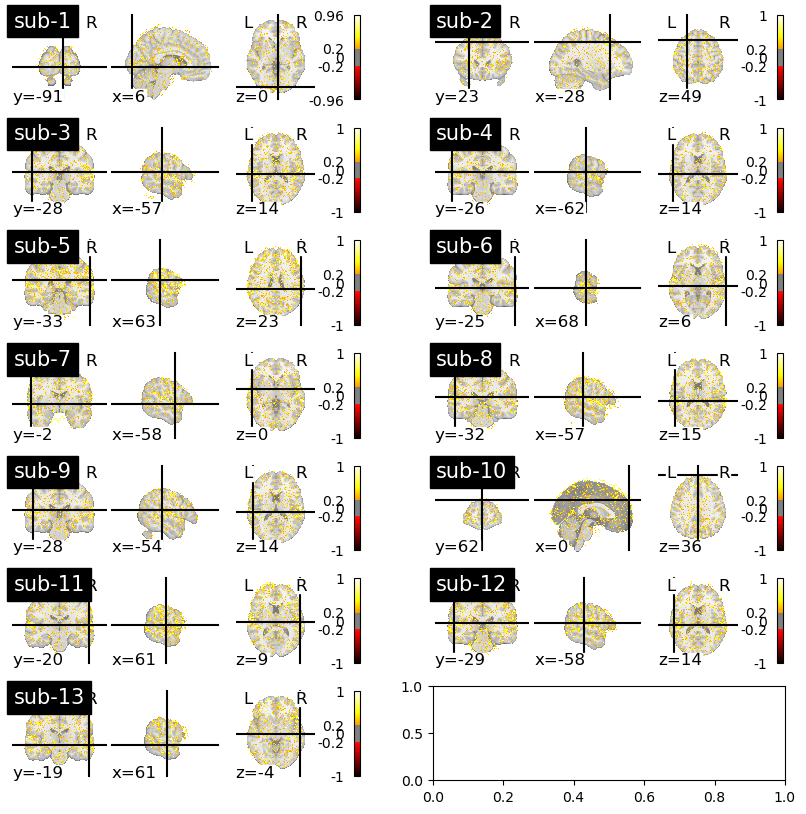

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(7, 2, figsize=(10, 10))
n_subjects  = 13
for ss in range(n_subjects):
    # plot the stability map
    aux = nb.Nifti1Image(STAB[...,ss], D.affine, D.header)
    plotting.plot_stat_map(aux, threshold=thres, title=f'sub-{ss+1}', colorbar=True, cmap='hot', axes=ax[ss//2, ss%2])


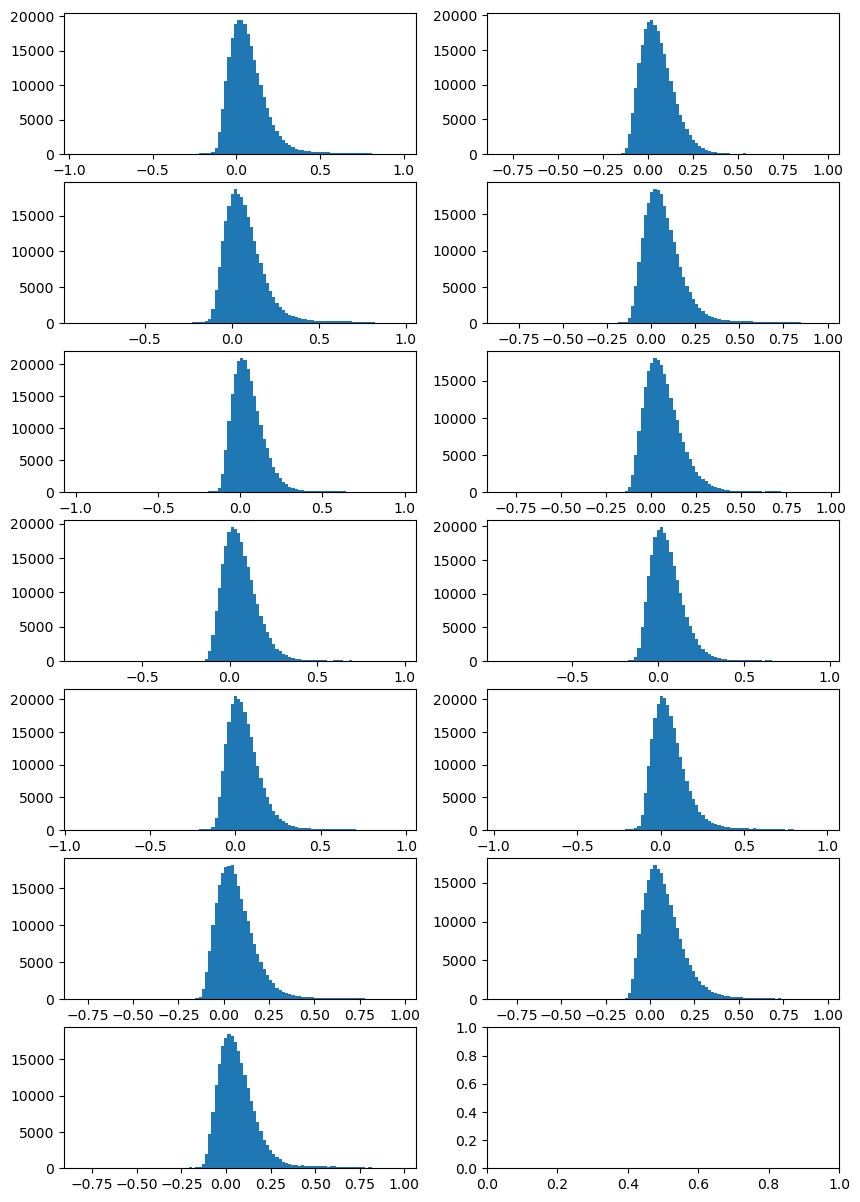

In [86]:
fig, ax = plt.subplots(7, 2, figsize=(10, 15))

for ss in range(n_subjects):
    # plot histogram of STAB[...,ss]
    ax[ss//2, ss%2].hist(STAB[...,ss].flatten(), bins=100)